## 时间事件日志

个人时间统计工具。要点：

* 使用 dida365.com 来作为 GTD 工具
* 使用特殊格式记录事件类别和花费的时间，如： “*[探索发现] 体验 iMac 开发环境 [3h]*”
* 导出数据
* 分析数据

### 读取数据

分析并读取数据

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from matplotlib.font_manager import FontManager
import subprocess    

def get_support_chinese_font():
    fm = FontManager()
    mat_fonts = set(f.name for f in fm.ttflist)

    output = subprocess.check_output('fc-list :lang=zh -f "%{family}\n"', shell=True)
    print '*' * 10, '系统可用的中文字体', '*' * 10
    print output
    zh_fonts = set(f.split(',', 1)[0] for f in output.split('\n'))
    available = mat_fonts & zh_fonts

    print '*' * 10, '可用的中文字体', '*' * 10
    for f in available:
        print f
    return available

In [3]:
from matplotlib.pylab import mpl

mpl.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [4]:
def _date_parser(dstr):
    return pd.Timestamp(dstr).date()

data = pd.read_csv('data/dida365.csv', header=3, index_col='Due Date', parse_dates=True, date_parser=_date_parser)
data.head()

,List Name,Title,Content,Is Checklist,Reminder,Repeat,Priority,Status,Completed Time,Order,Timezone,Is All Day
Due Date,,,,,,,,,,,,
2016-05-24,自我成长,[编程] javascript exercism [1h],NaN,N,NaN,NaN,0,2,2016-05-25T14:15:10+0000,-235295488344064,Asia/Shanghai,True
2016-05-23,自我成长,[编程] javascript exercism [0.5h],NaN,N,NaN,NaN,0,2,2016-05-24T15:59:08+0000,-234195976716288,Asia/Shanghai,True
2016-05-23,自我成长,[编程] clojure ring request [2h],阅读 ring.util.request 源码\r,N,NaN,NaN,0,2,2016-05-24T15:58:56+0000,-233096465088512,Asia/Shanghai,True
2016-05-22,自我成长,[编程] clojure ring 入门 [30m],NaN,N,NaN,NaN,0,2,2016-05-23T15:03:24+0000,-231996953460736,Asia/Shanghai,True
2016-05-22,自我成长,[探索发现] 体验 iMac 开发环境 [3h],iMac 的屏幕体验很棒，但使用非SSD硬盘速度上和mpb想着非常多。\r,N,NaN,NaN,0,2,2016-05-23T14:33:35+0000,-230897441832960,Asia/Shanghai,True


### 数据清洗

* 只关心己完成或己达成的事件，即 `status != 0` 的事件
* 只需要 `List Name` 和 `Title` 字段

In [5]:
df = data[data['Status'] != 0].loc[:, ['List Name', 'Title']]
df.head()

,List Name,Title
Due Date,,
2016-05-24,自我成长,[编程] javascript exercism [1h]
2016-05-23,自我成长,[编程] javascript exercism [0.5h]
2016-05-23,自我成长,[编程] clojure ring request [2h]
2016-05-22,自我成长,[编程] clojure ring 入门 [30m]
2016-05-22,自我成长,[探索发现] 体验 iMac 开发环境 [3h]


### 数据解析

解析事件类别和和花费的时间

In [6]:
import re

def parse_tag(value):
    m = re.match(r'^(\[(.*?)\])?.*$', value)
    if m and m.group(2):
        return m.group(2)
    else:
        return '其他'

def parse_duration(value):
    m = re.match(r'^.+?\[(.*?)([hm]?)\]$', value)
    if m:
        dur = 0
        try:
            dur = float(m.group(1))
        except e:
            print('parse duration error: \n%s' % e)
        if m.group(2) == 'm':
            dur = dur / 60.0
        return dur
    else:
        return 0
    
titles = df['Title']
df['Tag'] = titles.map(parse_tag)
df['Duration'] = titles.map(parse_duration)
df.head()

,List Name,Title,Tag,Duration
Due Date,,,,
2016-05-24,自我成长,[编程] javascript exercism [1h],编程,1.0
2016-05-23,自我成长,[编程] javascript exercism [0.5h],编程,0.5
2016-05-23,自我成长,[编程] clojure ring request [2h],编程,2.0
2016-05-22,自我成长,[编程] clojure ring 入门 [30m],编程,0.5
2016-05-22,自我成长,[探索发现] 体验 iMac 开发环境 [3h],探索发现,3.0


In [7]:
df.count()

List Name    232
Title        232
Tag          232
Duration     232
dtype: int64

In [8]:
start_date = df.index.min().date()
start_date

datetime.date(2015, 12, 2)

In [9]:
end_date = df.index.max().date()
end_date

datetime.date(2016, 5, 24)

### 数据分析

#### 时间总览

平均每天投资在自己身上的时间是多少？-> *全部时间 / 总天数*

In [10]:
end_date - start_date

datetime.timedelta(174)

In [11]:
df['Duration'].sum() 

482.19999999999999

In [12]:
df['Duration'].sum() / (end_date - start_date).days

2.7712643678160918

#### 精力分配

In [13]:
tag_list = df.groupby(['Tag']).sum()
tag_list

,Duration
Tag,
写作,49.0
探索发现,54.5
机器学习,33.5
电影,50.8
编程,243.4
阅读,51.0


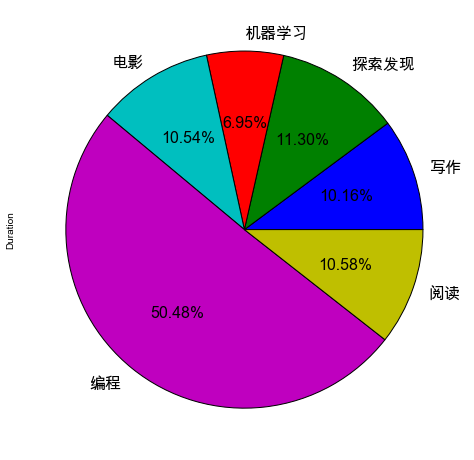

In [14]:
tag_list['Duration'].plot(kind='pie', figsize=(8, 8), fontsize=16, autopct='%1.2f%%')

#### 专注力

长时间学习某项技能的能力

In [15]:
programming = df[df['Tag'] == '编程']
programming.head()

,List Name,Title,Tag,Duration
Due Date,,,,
2016-05-24,自我成长,[编程] javascript exercism [1h],编程,1.0
2016-05-23,自我成长,[编程] javascript exercism [0.5h],编程,0.5
2016-05-23,自我成长,[编程] clojure ring request [2h],编程,2.0
2016-05-22,自我成长,[编程] clojure ring 入门 [30m],编程,0.5
2016-05-22,自我成长,[编程] javascript exercism [0.5h],编程,0.5


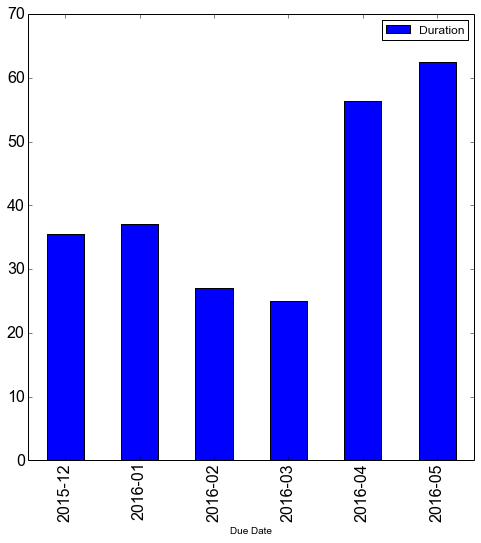

In [16]:
programming.resample('m', how='sum').to_period(freq='m').plot(kind='bar', figsize=(8, 8), fontsize=16)

#### 连续时间的精力分配

以时间为横轴，查看精力分配。

In [17]:
# 为什么不直接使用 df.pivot()? 因为有重复的行索引，如 2016-05-23
date_tags = df.reset_index().groupby(['Due Date', 'Tag']).sum()
date_tags

Duration
Due Date   Tag           
2015-12-02 写作         3.0
2015-12-04 阅读         3.0
2015-12-06 写作         4.0
           机器学习       3.0
2015-12-07 写作         1.0
2015-12-08 机器学习       1.0
           编程         4.0
2015-12-09 写作         4.0
2015-12-10 探索发现       0.5
           编程         5.5
2015-12-11 写作         1.5
           编程         4.0
           阅读         4.0
2015-12-12 写作         2.0
           机器学习       1.5
2015-12-13 编程         6.0
2015-12-14 阅读         1.0
2015-12-15 机器学习       2.5
           阅读         1.0
2015-12-16 探索发现       1.0
           机器学习       1.5
           编程         3.0
           阅读         1.0
2015-12-17 机器学习       2.0
2015-12-18 写作         1.5
           机器学习       1.0
           编程         3.0
2015-12-19 探索发现       7.0
           阅读         0.5
2015-12-20 写作         1.0
...                   ...
2016-04-24 编程         3.5
2016-04-25 编程         3.0
2016-04-26 编程         3.0
2016-04-29 编程         2.0
2016-04-30 编程         2.0
2016-05-01 编程         3.0
2016-05-02 编程         2.0
2016-05-03 编程         2.0
2016-05-04 编程         3.0
2016-05-05 编程         4.0
2016-05-06 编程         4.0
2016-05-07 编程         4.0
2016-05-08 编程         4.0
2016-05-09 编程         4.0
2016-05-10 编程         4.0
2016-05-11 编程         2.0
2016-05-12 编程         3.0
2016-05-13 探索发现       1.0
           编程         3.0
2016-05-14 探索发现       1.0
           编程         5.0
2016-05-15 编程         1.0
2016-05-17 编程         3.0
2016-05-18 编程         2.0
2016-05-19 编程         1.0
2016-05-20 编程         4.0
2016-05-22 探索发现       3.0
           编程         1.0
2016-05-23 编程         2.5
2016-05-24 编程         1.0

[187 rows x 1 columns]

In [18]:
# 以 tag 作为列索引
dates = date_tags.reset_index().pivot(index='Due Date', columns='Tag', values='Duration')
dates

Tag,写作,探索发现,机器学习,电影,编程,阅读
Due Date,,,,,,
2015-12-02,3.0,NaN,NaN,NaN,NaN,NaN
2015-12-04,NaN,NaN,NaN,NaN,NaN,3.0
2015-12-06,4.0,NaN,3.0,NaN,NaN,NaN
2015-12-07,1.0,NaN,NaN,NaN,NaN,NaN
2015-12-08,NaN,NaN,1.0,NaN,4.0,NaN
2015-12-09,4.0,NaN,NaN,NaN,NaN,NaN
2015-12-10,NaN,0.5,NaN,NaN,5.5,NaN
2015-12-11,1.5,NaN,NaN,NaN,4.0,4.0
2015-12-12,2.0,NaN,1.5,NaN,NaN,NaN


In [19]:
# 补足连续时间，可以看到哪些天没有在学习
full_dates = dates.reindex(pd.date_range(start_date, end_date)).fillna(0)
full_dates

Tag,写作,探索发现,机器学习,电影,编程,阅读
2015-12-02,3.0,0.0,0.0,0,0.0,0.0
2015-12-03,0.0,0.0,0.0,0,0.0,0.0
2015-12-04,0.0,0.0,0.0,0,0.0,3.0
2015-12-05,0.0,0.0,0.0,0,0.0,0.0
2015-12-06,4.0,0.0,3.0,0,0.0,0.0
2015-12-07,1.0,0.0,0.0,0,0.0,0.0
2015-12-08,0.0,0.0,1.0,0,4.0,0.0
2015-12-09,4.0,0.0,0.0,0,0.0,0.0
2015-12-10,0.0,0.5,0.0,0,5.5,0.0
2015-12-11,1.5,0.0,0.0,0,4.0,4.0


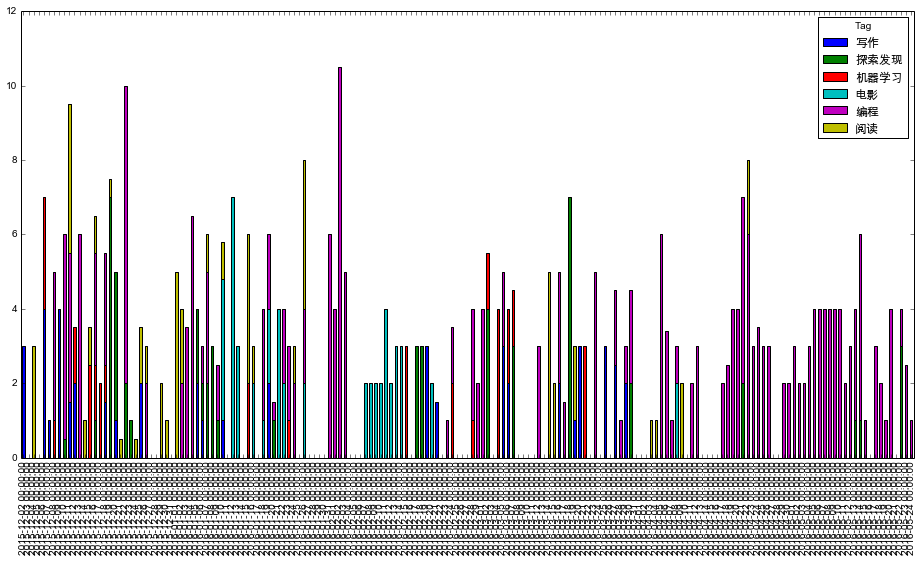

In [20]:
# 画出柱状图
full_dates.plot(kind='bar', stacked=True, figsize=(16, 8))

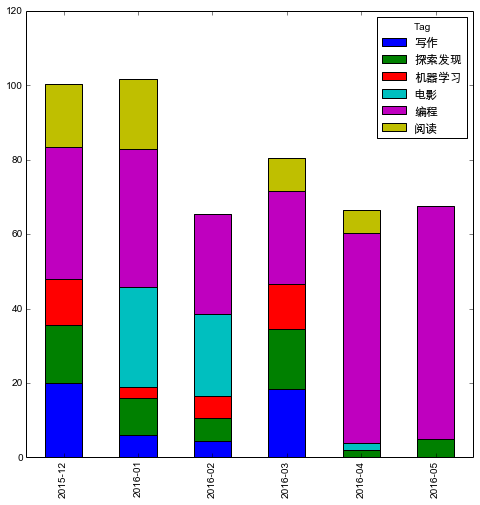

In [21]:
full_dates.resample('m', how='sum').to_period('m').plot(kind='bar', stacked=True, figsize=(8, 8))

## 时间事件日志

感兴趣的同学可以参阅 https://github.com/kamidox/utils 。